### General Information

Team Name: Liad & Yuval

IDs:

ID #1: 300822954

ID #2: 311434047

**Note: open in colab & consider using table of contents to ease the nagivation**

### Required Installation

In [1]:
!pip install xgboost
!pip install sklearn_pandas
!pip install shap
!pip install pycm

     |████████████████████████████████| 327kB 3.4MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456458 sha256=b7b821ee2bd9a7e39787f72ad2380682ba1d85400f2bd8caf57ac6aa98ca5ebd
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap
     |████████████████████████████████| 61kB 2.1MB/s 
     |████████████████████████████████| 552kB 9.3MB/s 


### Settings

In [2]:
run_nested_cross_validation = False

### Imports section

In [3]:
import os
import time
import tarfile
from shutil import rmtree
import zipfile

import numpy as np
import pandas as pd
from sklearn import datasets
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import type_of_target
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost
from sklearn_pandas import DataFrameMapper
from sklearn_pandas import gen_features
from sklearn_pandas import CategoricalImputer
from sklearn.model_selection import LeaveOneOut
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
import shap
from pycm import ConfusionMatrix
from enum import Enum
from typing import Tuple
import random
from imblearn.over_sampling import RandomOverSampler
from hyperopt import hp
import random
from hyperopt.pyll import scope

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.


### Seed

In [4]:
random_state=0

### Part 1 - A Model Without an Implementation

We choose to implement the following paper:

**Zhang, Chun-Xia, and Jiang-She Zhang. "RotBoost: A technique for combining Rotation Forest and AdaBoost." Pattern recognition letters 29, no. 10 (2008): 1524-1536.**

#### RotBoost Implementation

In [5]:
import numpy as np
from sklearn.base import BaseEstimator, clone
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble._forest import ForestClassifier
from sklearn.exceptions import NotFittedError
from sklearn.utils import resample, gen_batches, check_random_state
from sklearn.utils.multiclass import type_of_target
from sklearn.utils.validation import _check_sample_weight
import random

def random_feature_subsets(array, batch_size, random_state=0):
    """ Generate K subsets of the features in X """
    random_state = check_random_state(random_state)
    features = list(range(array.shape[1]))
    random_state.shuffle(features)
    for batch in gen_batches(len(features), batch_size):
        yield features[batch]


class RotBoostAdaBoostClassifier(AdaBoostClassifier):
    def __init__(self,
                 base_estimator=None,
                 n_estimators=30,
                 learning_rate=1.,
                 random_state=None):

        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.random_state = random_state

        super(RotBoostAdaBoostClassifier, self).__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            algorithm='SAMME',  # our version of adaboost is compatible for binary classification,
                                # for multi-class wrap using OneVsRestClassifier or OneVsOneClassifier
            random_state=random_state)

    def _boost(self, iboost, X, y, sample_weight, random_state):
        """Implement a single boost using the adaboost showed in the RotBoost algorithm, not sklearn SAMME"""
        estimator = self._make_estimator(random_state=random_state)

        estimator.fit(X, y, sample_weight=sample_weight)

        y_predict = estimator.predict(X)

        if iboost == 0:
            self.classes_ = getattr(estimator, 'classes_', None)
            self.n_classes_ = len(self.classes_)

        # Instances incorrectly classified
        incorrect = y_predict != y

        # Error fraction
        estimator_error = np.mean(np.average(incorrect, weights=sample_weight, axis=0))

        # if classification is perfect then incorporate into the ensemble with
        # estimator_error=10^-10 instead of stopping
        if estimator_error <= 0:
            estimator_error = pow(10, -10)

        n_classes = self.n_classes_

        # in order to prevent early-stopping when has estimator_error bigger than random classifier, we are going to
        # initialize the sample_weight and try again
        if estimator_error >= 1. - (1. / n_classes):
            self.estimators_.pop(-1)

            sample_weight = _check_sample_weight(None, X, np.float64)
            sample_weight /= sample_weight.sum()
            if np.any(sample_weight < 0):
                raise ValueError("sample_weight cannot contain negative weights")

            return self._boost(iboost, X, y, sample_weight, random_state)

        # Boost weight
        estimator_weight = self.learning_rate * (0.5 * np.log((1. - estimator_error) / estimator_error))

        # Only boost the weights if I will fit again
        if not iboost == self.n_estimators - 1:
            # Only boost positive weights
            sample_weight *= np.exp(estimator_weight * incorrect *
                                    (sample_weight > 0))

        return sample_weight, estimator_weight, estimator_error


class RotBoostRotationAdaBoostClassifier(BaseEstimator):
    def __init__(self,
                 adaboost_base_estimator=None,
                 n_estimators_of_adaboost=30,
                 adaboost_learning_rate=1.,
                 n_features_per_subset=3,
                 rotation_algo='pca',
                 random_state=None):

        self.adaboost_base_estimator = adaboost_base_estimator
        self.n_estimators_of_adaboost = n_estimators_of_adaboost
        self.adaboost_learning_rate = adaboost_learning_rate
        self.n_features_per_subset = n_features_per_subset
        self.rotation_algo = rotation_algo
        self.random_state = random_state

        self.adaboost_classifier = RotBoostAdaBoostClassifier(
            base_estimator=adaboost_base_estimator,
            n_estimators=n_estimators_of_adaboost,
            learning_rate=adaboost_learning_rate,
            random_state=random_state)

    def rotate(self, X):
        if not hasattr(self, 'rotation_matrix'):
            raise NotFittedError('The estimator has not been fitted')

        return np.dot(X, self.rotation_matrix)

    def pca_algorithm(self):
        """ Deterimine PCA algorithm to use. """
        if self.rotation_algo == 'randomized':
            return PCA(svd_solver='randomized', random_state=self.random_state)
        elif self.rotation_algo == 'pca':
            return PCA()
        else:
            raise ValueError("`rotation_algo` must be either "
                             "'pca' or 'randomized'.")

    def _fit_rotation_matrix(self, X):
        seed = check_random_state(None)
        n_samples, n_features = X.shape
        self.rotation_matrix = np.zeros((n_features, n_features),
                                        dtype=np.float32)
        for i, subset in enumerate(
                random_feature_subsets(X, self.n_features_per_subset,
                                       random_state=seed)):
            # take a 75% bootstrap from the rows
            x_sample = resample(X, n_samples=int(n_samples*0.75),
                                random_state=check_random_state(random.randrange(10)*(i+1)))
            pca = self.pca_algorithm()
            pca.fit(x_sample[:, subset])
            self.rotation_matrix[np.ix_(subset, subset)] = pca.components_

    def fit(self, X, y, sample_weight=None, check_input=False):
        self._fit_rotation_matrix(X)

        if type_of_target(y) not in 'binary':
            raise NotImplementedError("RotBoost doesn't support multi-class y")

        self.adaboost_classifier = clone(self.adaboost_classifier)
        self.adaboost_classifier.fit(self.rotate(X), y.reshape(1, -1)[0], sample_weight)

    def predict_proba(self, X, check_input=False):
        return self.adaboost_classifier.predict_proba(self.rotate(X))

    def predict(self, X):
        return self.adaboost_classifier.predict(self.rotate(X))

    def _validate_X_predict(self, X, check_input=False):
        return X


class RotBoostClassifier(ForestClassifier):
    def __init__(self,
                 adaboost_base_estimator=None,  # default base estimator is a DecisionTreeClassifier(max_depth=2)
                 n_estimators=10,
                 n_estimators_of_adaboost=30,
                 n_features_per_subset=3,
                 rotation_algo='pca',
                 adaboost_learning_rate=1.,
                 bootstrap=False,
                 oob_score=False,
                 n_jobs=1,
                 random_state=None,
                 verbose=0):
        super(RotBoostClassifier, self).__init__(
            base_estimator=RotBoostRotationAdaBoostClassifier(adaboost_base_estimator, n_estimators_of_adaboost,
                                                              adaboost_learning_rate, n_features_per_subset,
                                                              rotation_algo, random_state),
            estimator_params=("adaboost_base_estimator", "n_estimators_of_adaboost",
                              "adaboost_learning_rate", "n_features_per_subset", "rotation_algo", "random_state"),
            n_estimators=n_estimators,
            bootstrap=bootstrap,
            oob_score=oob_score,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose)

        self.n_features_per_subset = n_features_per_subset
        self.rotation_algo = rotation_algo
        self.adaboost_base_estimator = adaboost_base_estimator
        self.n_estimators_of_adaboost = n_estimators_of_adaboost
        self.adaboost_learning_rate = adaboost_learning_rate


### Part 2 - Known Model

#### Rotation-Forest implementation

In [6]:
import numpy as np
from sklearn.exceptions import NotFittedError

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree._tree import DTYPE
from sklearn.ensemble._forest import ForestClassifier
from sklearn.utils import resample, gen_batches, check_random_state
from sklearn.decomposition import PCA
import random


def random_feature_subsets(array, batch_size, random_state=1234):
    """ Generate K subsets of the features in X """
    random_state = check_random_state(random_state)
    features = list(range(array.shape[1]))
    random_state.shuffle(features)
    for batch in gen_batches(len(features), batch_size):
        yield features[batch]


class RotationTreeClassifier(DecisionTreeClassifier):
    def __init__(self,
                 n_features_per_subset=3,
                 rotation_algo='pca',
                 criterion="gini",
                 splitter="best",
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.,
                 max_features=1.0,
                 random_state=None,
                 max_leaf_nodes=None,
                 class_weight=None,
                 presort=False):

        self.n_features_per_subset = n_features_per_subset
        self.rotation_algo = rotation_algo

        super(RotationTreeClassifier, self).__init__(
            criterion=criterion,
            splitter=splitter,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=min_weight_fraction_leaf,
            max_features=max_features,
            max_leaf_nodes=max_leaf_nodes,
            class_weight=class_weight,
            random_state=random_state,
            presort=presort)

    def rotate(self, X):
        if not hasattr(self, 'rotation_matrix'):
            raise NotFittedError('The estimator has not been fitted')

        return np.dot(X, self.rotation_matrix)

    def pca_algorithm(self):
        """ Deterimine PCA algorithm to use. """
        if self.rotation_algo == 'randomized':
            return PCA(svd_solver='randomized', random_state=self.random_state)
        elif self.rotation_algo == 'pca':
            return PCA()
        else:
            raise ValueError("`rotation_algo` must be either "
                             "'pca' or 'randomized'.")

    def _fit_rotation_matrix(self, X):
        seed = check_random_state(None)
        n_samples, n_features = X.shape
        self.rotation_matrix = np.zeros((n_features, n_features),
                                        dtype=np.float32)
        for i, subset in enumerate(
                random_feature_subsets(X, self.n_features_per_subset,
                                       random_state=seed)):
            # take a 75% bootstrap from the rows
            x_sample = resample(X, n_samples=int(n_samples*0.75),
                                random_state=check_random_state(random.randrange(10)*(i+1)))
            pca = self.pca_algorithm()
            pca.fit(x_sample[:, subset])
            self.rotation_matrix[np.ix_(subset, subset)] = pca.components_

    def fit(self, X, y, sample_weight=None, check_input=True):
        self._fit_rotation_matrix(X)
        super(RotationTreeClassifier, self).fit(self.rotate(X), y,
                                                sample_weight, check_input)

    def predict_proba(self, X, check_input=True):
        return  super(RotationTreeClassifier, self).predict_proba(self.rotate(X),
                                                                  check_input)

    def predict(self, X, check_input=True):
        return super(RotationTreeClassifier, self).predict(self.rotate(X),
                                                           check_input)

    def apply(self, X, check_input=True):
        return super(RotationTreeClassifier, self).apply(self.rotate(X),
                                                         check_input)

    def decision_path(self, X, check_input=True):
        return super(RotationTreeClassifier, self).decision_path(self.rotate(X),
                                                                 check_input)

class RotationForestClassifier(ForestClassifier):
    def __init__(self,
                 n_estimators=10,
                 criterion="gini",
                 n_features_per_subset=3,
                 rotation_algo='pca',
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.,
                 max_features=1.0,
                 max_leaf_nodes=None,
                 bootstrap=False,
                 oob_score=False,
                 n_jobs=1,
                 random_state=None,
                 verbose=0,
                 warm_start=False,
                 class_weight=None):
        super(RotationForestClassifier, self).__init__(
            base_estimator=RotationTreeClassifier(n_features_per_subset, max_depth=max_depth,
                                                  min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=random_state),
            n_estimators=n_estimators,
            estimator_params=("n_features_per_subset", "rotation_algo",
                              "criterion", "max_depth", "min_samples_split",
                              "min_samples_leaf", "min_weight_fraction_leaf",
                              "max_features", "max_leaf_nodes",
                              "random_state"),
            bootstrap=bootstrap,
            oob_score=oob_score,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose,
            warm_start=warm_start,
            class_weight=class_weight)

        self.n_features_per_subset = n_features_per_subset
        self.rotation_algo = rotation_algo
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes


We choose to compare with Rotation-Forest model. Github: https://github.com/digital-idiot/RotationForest

### Part 3 - Models Expirements And Comparison

#### Utilities

In [7]:
def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]


def find_empty_columns(df: pd.DataFrame) -> list:
    empty_cols = [col for col in df.columns if df[col].isnull().all()]

    return empty_cols


def find_columns_with_missing_values(df: pd.DataFrame) -> list:
    return df.columns[df.isnull().any()].to_list()


def find_columns_that_have_at_most_N_unique_values(df: pd.DataFrame, N, dropna=True) -> list:
    temp_df = df.loc[:, df.nunique(dropna=dropna) <= N]

    if temp_df.empty:
        return []

    return temp_df.columns.to_list()


def find_columns_with_one_value_for_all_rows(df: pd.DataFrame, dropna=True) -> list:
    return find_columns_that_have_at_most_N_unique_values(df, 1, dropna=dropna)


def save_model_into_file(estimator, file_name, path=''):
    dump(estimator, path + file_name + '.joblib')


def apply_numeric_impute_mapper_on_data(input_df: pd.DataFrame, strategy: str = 'mean') -> (pd.DataFrame, DataFrameMapper):
    columns = input_df.select_dtypes(include=np.number).columns.tolist()
    if len(columns) == 0:
        return input_df, None

    transformed_columns = [[col] for col in input_df.select_dtypes(include=np.number).columns.tolist()]

    classes = [{'class': SimpleImputer, 'strategy': strategy, 'fill_value': -9999999}]

    feature_def = gen_features(
        columns=transformed_columns,
        classes=classes
    )

    mapper = DataFrameMapper(feature_def, input_df=True, df_out=True)

    input_df_transformed = mapper.fit_transform(input_df.copy())

    input_df[mapper.transformed_names_] = input_df_transformed

    return input_df, mapper


def apply_categorical_impute_mapper_on_data(input_df: pd.DataFrame, strategy: str = 'constant') -> (pd.DataFrame, DataFrameMapper):
    columns = input_df.select_dtypes("object").columns.tolist()
    if len(columns) == 0:
        return input_df, None

    if strategy == 'most_frequent':
        mapper = DataFrameMapper(
            [([category_feature], SimpleImputer(strategy='most_frequent')) for category_feature in columns],
            input_df=True, df_out=True)
    else:
        transformed_columns = [[col] for col in columns]

        classes = [{'class': SimpleImputer, 'strategy': strategy, 'fill_value': 'missing_value'}]

        feature_def = gen_features(
            columns=transformed_columns,
            classes=classes
        )

        mapper = DataFrameMapper(feature_def, input_df=True, df_out=True)

    input_df_transformed = mapper.fit_transform(input_df.copy())

    input_df[mapper.transformed_names_] = input_df_transformed

    return input_df, mapper


def apply_ohe_mapper_on_data(input_df: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([pd.get_dummies(input_df[col], prefix=col) if input_df[col].dtype == object else input_df[col] for col in input_df], axis=1)


def apply_scaler_mapper_on_data(input_df: pd.DataFrame, scaler=StandardScaler) -> (pd.DataFrame, DataFrameMapper):
    columns = input_df.select_dtypes(include=np.number).columns.tolist()
    if len(columns) == 0:
        return input_df, None

    transformed_columns = [[col] for col in columns]

    feature_def = gen_features(
        columns=transformed_columns,
        classes=[scaler]
    )

    mapper = DataFrameMapper(feature_def, input_df=True, df_out=True)

    input_df_transformed = mapper.fit_transform(input_df.copy())

    input_df[mapper.transformed_names_] = input_df_transformed

    return input_df, mapper


def transform_categorical_column_using_label_encoder(df: pd.DataFrame, column: str) -> tuple:
    if df[column].dtype != 'object':
        return df, None

    le = LabelEncoder()

    df[column] = le.fit_transform(df[column])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

    return df, le_name_mapping


def preprocessing_dataset(X: pd.DataFrame) -> pd.DataFrame:
    X, _ = apply_numeric_impute_mapper_on_data(X)
    X, _ = apply_scaler_mapper_on_data(X)
    X, _ = apply_categorical_impute_mapper_on_data(X)
    X = apply_ohe_mapper_on_data(X)

    # remove columns with one value
    columns_with_one_value = find_columns_with_one_value_for_all_rows(X)
    if len(columns_with_one_value) > 0:
        X.drop(columns_with_one_value, axis=1, inplace=True)

    return X


def preprocessing_all_datasets(datasets_path: str,
                               transformed_datasets_path: str,
                               y_sampling_min_num: int = 10) -> None:
    """
    Preprocessing all datasets in the given path:
    Removing columns where all samples' value is nan/empty
    Apply 'mean' numeric imputer + standard scaling
    Apply 'constant' categorical imputer + one-hot-encoding
    Perform random over sampler for imbalaned classification data-set
    """
    for dataset_filename in sorted(os.listdir(datasets_path)):
        print("Preprocessing dataset '{}'".format(dataset_filename))

        dataset_filename_pkl = transformed_datasets_path + '/' + dataset_filename + '.pkl'
        if os.path.exists(dataset_filename_pkl):
            os.remove(dataset_filename_pkl)

        df = pd.read_csv(datasets_path + '/' + dataset_filename)

        if dataset_filename == 'analcatdata_germangss.csv':
            # 'Political_system' is the target column
            df = df[["Age", "Time_of_survey", "Schooling", "Region", "Count", "Political_system"]]

        # we assume the labels are located at the last column
        target_column_name = df.columns[-1]

        df, _ = transform_categorical_column_using_label_encoder(df, target_column_name)

        # split data into X & y convention
        X, y = df.drop([target_column_name], axis=1), df[[target_column_name]]

        # Find the columns where all samples' value is nan/empty
        empty_cols = find_empty_columns(X)

        # Drop empty columns from the dataframe
        if len(empty_cols) > 0:
            print("Dataset '{}', found empty columns [{}]".format(dataset_filename, empty_cols))
            X.drop(empty_cols, axis=1, inplace=True)

        X_transformed = preprocessing_dataset(X)

        # check for imbalanced classification data-set, perform random over sampler
        columns = X_transformed.columns.to_list()
        y_value_counts = y[target_column_name].value_counts().to_dict()
        y_sampling_strategy = {label: count if count >= y_sampling_min_num else y_sampling_min_num for (label, count) in y_value_counts.items()}
        ros = RandomOverSampler(sampling_strategy=y_sampling_strategy, random_state=0)
        X_transformed, y_transformed = ros.fit_resample(X_transformed, y[target_column_name])

        df_transformed = pd.concat([pd.DataFrame(data=X_transformed, columns=columns), pd.DataFrame(data=y_transformed, columns=[target_column_name])], axis=1)
        
        df_transformed.to_pickle(transformed_datasets_path + '/' + dataset_filename + '.pkl')


def one_vs_rest_pr_auc_score(y_true, y_score):
    """
    Generates the Area Under the Curve for precision and recall in one-vs-rest fashion.
    Also, precision and recall metrics.
    """
    classes = np.unique(y_true)
    n_classes = len(classes)

    if n_classes != y_score.shape[1]:
        raise ValueError(
            "Number of classes in y_true not equal to the number of "
            "columns in 'y_score'")

    y_type = type_of_target(y_true)
    if y_type in 'binary':
        precision, recall, _ = precision_recall_curve(y_true, y_score[:, 1])
        return auc(recall, precision)

    y_true_multilabel = label_binarize(y_true, classes=classes)

    pr_auc_scores = np.zeros((n_classes,))

    for c in range(n_classes):
        y_true_c = y_true_multilabel.take([c], axis=1).ravel()
        y_score_c = y_score.take([c], axis=1).ravel()

        precision_c, recall_c, _ = precision_recall_curve(y_true_c, y_score_c)
        pr_auc_c = auc(recall_c, precision_c)

        pr_auc_scores[c] = pr_auc_c

    return np.average(pr_auc_scores)


def accuracy_macro_score(y_true, y_pred):
    cm = ConfusionMatrix(y_true, y_pred)
    return cm.ACC_Macro


def tpr_score(y_true, y_pred):
    cm = ConfusionMatrix(y_true, y_pred)
    return np.array(list(cm.TPR.values())).mean()


def fpr_score(y_true, y_pred):
    cm = ConfusionMatrix(y_true, y_pred)
    return np.array(list(cm.FPR.values())).mean()


def measure_sec_of_n_sample_predictions(model, X, n=1000):
    samples = X.copy()

    if samples.shape[0] > n:
        samples = samples.loc[:n-1, :]

    number_of_samples = samples.shape[0]

    start = time.time()
    _ = model.predict(samples)
    stop = time.time()

    prediction_time_sec = (stop - start) * (n / number_of_samples)

    return prediction_time_sec


#### Datasets Pre-processing

In [8]:
transformed_datasets_dir_name = "/content/classification_datasets_transformed"

datasets_dir_name = "/content/classification_datasets"
zip_file = '/content/classification_datasets-20200531T065549Z-001.zip'

if not os.path.exists(datasets_dir_name):
    os.mkdir(datasets_dir_name)
else:
    rmtree(datasets_dir_name)

if not os.path.exists(transformed_datasets_dir_name):
    os.mkdir(transformed_datasets_dir_name)
else:
    rmtree(transformed_datasets_dir_name)
    os.mkdir(transformed_datasets_dir_name)

zf = zipfile.ZipFile(zip_file, 'r')
zf.extractall("/content")
zf.close()

preprocessing_all_datasets(datasets_dir_name, transformed_datasets_dir_name)

Preprocessing dataset 'abalon.csv'
Preprocessing dataset 'acute-inflammation.csv'
Preprocessing dataset 'acute-nephritis.csv'
Preprocessing dataset 'analcatdata_asbestos.csv'
Preprocessing dataset 'analcatdata_boxing1.csv'
Preprocessing dataset 'analcatdata_broadwaymult.csv'
Preprocessing dataset 'analcatdata_germangss.csv'
Preprocessing dataset 'analcatdata_lawsuit.csv'
Preprocessing dataset 'annealing.csv'
Preprocessing dataset 'ar4.csv'
Preprocessing dataset 'arrhythmia.csv'
Preprocessing dataset 'audiology-std.csv'
Preprocessing dataset 'autos.csv'
Preprocessing dataset 'balance-scale.csv'
Preprocessing dataset 'bank.csv'
Preprocessing dataset 'baseball.csv'
Preprocessing dataset 'blood.csv'
Preprocessing dataset 'bodyfat.csv'
Preprocessing dataset 'braziltourism.csv'
Preprocessing dataset 'breast-cancer-wisc-diag.csv'
Preprocessing dataset 'breast-cancer-wisc-prog.csv'
Preprocessing dataset 'breast-cancer-wisc.csv'
Preprocessing dataset 'breast-cancer.csv'
Preprocessing dataset 'b

#### Models + Param-Grids

In [9]:
models = [
    ('RotationForest', RotationForestClassifier(random_state=random_state, n_jobs=-1)),
    ('RotBoost', RotBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, n_jobs=-1))
]

param_grids = {
    'RotationForest': {
        'max_depth': hp.choice('max_depth', [None, scope.int(hp.choice('max_depth_int', np.arange(2, 200, 5, dtype=int)))]),
        'n_estimators': scope.int(hp.quniform('n_estimators', 1, 100, 1)),
        'n_features_per_subset': scope.int(hp.quniform('n_features_per_subset', 2, 6, 1)),
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, 1))
    },
     'RotBoost': {
         'n_estimators': scope.int(hp.quniform('n_estimators', 1, 10, 1)),
         'n_estimators_of_adaboost': scope.int(hp.quniform('n_estimators_of_adaboost', 1, 10, 1)),
         'n_features_per_subset': scope.int(hp.quniform('n_features_per_subset', 2, 6, 1)),
         'adaboost_learning_rate': hp.uniform('adaboost_learning_rate', 0.01, 1),
         'adaboost_base_estimator__max_depth': hp.choice('adaboost_base_estimator__max_depth', np.arange(1, 10, dtype=int))
     }
}

#### Expirements

##### Nested Cross-Validation class

In [10]:
import numbers
import time

import numpy as np
from hyperopt import fmin, Trials, tpe, space_eval
from sklearn import clone
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_validate
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils.multiclass import type_of_target


class CustomNestedCV:
    """A general class to handle nested cross-validation for any estimator that
    implements the scikit-learn estimator interface.
    Note: This solution is based on https://github.com/casperbh96/Nested-Cross-Validation library with a couple of
          tweaks & adjustments + support for bayes optimization without support for grid-search

    Parameters
    ----------
    model : estimator
        The estimator implements scikit-learn estimator interface.
    params_grid : dict
        The dict contains hyperparameters for model.
    dataset_name : str
        The Dataset name
    outer_cv : int or cv splitter class (e.g. KFold, StratifiedKFold etc.)
        Outer splitting strategy. If int, StratifiedKFold is default.
    inner_cv : int or cv splitter class (e.g. KFold, StratifiedKFold etc.)
        Inner splitting strategy. If int, StratifiedKFold is default.
    n_jobs : int
        Number of jobs to run in parallel
    random_state : int
        default=None, pass an int for reproducible output across multiple function calls
    cv_options: dict, default = {}
        metric : cv sklearn scorer, default = roc_auc_score
            A scoring metric used to score each model in the inner folds
        randomized_search : boolean, default = False
            Whether to use bayes search from hyperopt or randomized search from sklearn
        search_iter : int, default = 50
            Number of iterations for randomized search or bayesian search
        predict_proba : boolean, default = True
            If true, predict probabilities instead for a class, instead of predicting a class. Used for inner fold metric
        multiclass_average : string, default = 'macro'
            For some classification metrics with a multiclass prediction, you need to specify an
            average other than 'binary'
        multiclass_method : string, default = 'ovr'
            For some classification metrics with a multiclass attribute, you need to specify an
            method such as 'ovr', 'ovo' etc.
        verbose : int, default = 0
            Controls the verbosity: the higher, the more messages.
    wrap_model_using_ovr : boolean, default = False
        If true, wrap given model using One-Vs-rest classifier from sklearn.
    """

    def __init__(self, model, params_grid, dataset_name, outer_cv=10, inner_cv=3, n_jobs=1, random_state=None,
                 cv_options=None, wrap_model_using_ovr=False):
        if cv_options is None:
            cv_options = {}

        self.model = model
        self.params_grid = params_grid
        self.dataset_name = dataset_name
        self.outer_cv = outer_cv
        self.inner_cv = inner_cv
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.wrap_model_using_ovr = wrap_model_using_ovr
        self.scorer = cv_options.get('scorer', None)
        self.randomized_search = cv_options.get('randomized_search', True)
        self.search_iter = cv_options.get('search_iter', 50)
        self.predict_proba = cv_options.get('predict_proba', True)
        self.multiclass_average = cv_options.get('multiclass_average', 'macro')
        self.multiclass_method = cv_options.get('multiclass_method', 'ovr')
        self.verbose = cv_options.get('verbose', 0)

        self.outer_scores = []
        self.best_inner_params_list = []

        self.model.set_params(**{'random_state': self.random_state})

        if self.multiclass_average is not 'macro':
            raise NotImplementedError("Only 'macro' option is supported")

    def _predict_and_score_outer(self, X_test, y_test, outer_model):
        """A method for generating various metrics on current outer fold with best model found based on inner cv"""

        y_pred = outer_model.predict(X_test)
        y_pred_proba = outer_model.predict_proba(X_test)

        tpr = tpr_score(y_test.to_numpy().ravel(), y_pred)
        fpr = fpr_score(y_test.to_numpy().ravel(), y_pred)
        pr_auc = one_vs_rest_pr_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_macro_score(y_test.to_numpy().ravel(), y_pred)
        precision = precision_score(y_test, y_pred, average=self.multiclass_average)
        recall = recall_score(y_test, y_pred, average=self.multiclass_average)

        if self.y_type in 'binary':
            roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        else:
            roc_auc = roc_auc_score(y_test, y_pred_proba, average=self.multiclass_average,
                                    multi_class=self.multiclass_method)

        return accuracy, tpr, fpr, precision, recall, roc_auc, pr_auc

    def fit(self, X, y):
        """A method to fit nested cross-validation

        Parameters
        ----------
        X : pandas dataframe (rows, columns)
            Training dataframe, where rows is total number of observations and columns
            is total number of features
        y : pandas dataframe
            Output dataframe, also called output variable. y is what you want to predict.
        Returns
        -------
        It will not return directly the values, but it's accessible from the class object it self.
        You should be able to access:
        outer_scores
            Outer scores List.
        best_inner_params_list
            Best inner params for each outer loop as an array of dictionaries
        """

        print(f"\nDataset '{self.dataset_name}'")
        print('{} <-- Running this model now'.format(type(self.model).__name__))

        self.X = X
        self.y = y
        self.y_type = type_of_target(y)

        if isinstance(self.outer_cv, numbers.Number) and isinstance(self.inner_cv, numbers.Number):
            outer_cv = StratifiedKFold(n_splits=self.outer_cv, shuffle=True, random_state=self.random_state)
            inner_cv = StratifiedKFold(n_splits=self.inner_cv, shuffle=True, random_state=self.random_state)
        else:
            outer_cv = self.outer_cv
            inner_cv = self.inner_cv

        outer_scores = []
        best_inner_params_list = []

        # Split X and y into K-partitions to Outer CV
        for (i, (train_index, test_index)) in enumerate(outer_cv.split(X, y)):
            print('\n{}/{} <-- Current outer fold'.format(i+1, self.outer_cv))
            X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
            y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]

            if self.y_type in 'binary':
                auc_scorer = self.scorer if self.scorer is not None else make_scorer(roc_auc_score)
            else:
                auc_scorer = self.scorer if self.scorer is not None else make_scorer(roc_auc_score,
                                                                                     average=self.multiclass_average,
                                                                                     needs_proba=self.predict_proba,
                                                                                     multi_class=self.multiclass_method)

            if self.randomized_search:
                randomized_search_inner_model = clone(self.model)
                search_model = randomized_search_inner_model

                if self.wrap_model_using_ovr:
                    one_vs_rest_randomized_inner_classifier = OneVsRestClassifier(randomized_search_inner_model)
                    search_model = one_vs_rest_randomized_inner_classifier

                randomized_search_cv = RandomizedSearchCV(search_model,
                                                          param_distributions=self.params_grid,
                                                          scoring=auc_scorer,
                                                          cv=inner_cv,
                                                          n_iter=self.search_iter,
                                                          verbose=self.verbose,
                                                          n_jobs=self.n_jobs,
                                                          random_state=self.random_state)
                randomized_search_cv.fit(X_train_outer, y_train_outer)

                best_inner_params = randomized_search_cv.best_params_
            else:
                def objective(params, cv=inner_cv, X_inner=X_train_outer, y_inner=y_train_outer, scorer=auc_scorer):
                    bayes_search_inner_model = clone(self.model)
                    bayes_search_inner_model.set_params(**params)
                    bayes_search_inner_model = clone(bayes_search_inner_model)
                    search_model = bayes_search_inner_model

                    if self.wrap_model_using_ovr and self.y_type not in 'binary':
                        search_model = OneVsRestClassifier(bayes_search_inner_model)

                    cv_search = cross_validate(search_model, X_inner, y_inner, scoring=scorer, cv=cv,
                                               n_jobs=self.n_jobs, verbose=self.verbose)
                    cv_test_score = cv_search['test_score'].mean()

                    # should minimize
                    loss = 1 - cv_test_score

                    if self.verbose > 1:
                        print("Bayesian search iteration params: {}".format(params))
                        print("Bayesian search iteration loss: {}".format(loss))
                        print()

                    return loss

                trials = Trials()
                best_inner_params = fmin(fn=objective, space=self.params_grid, max_evals=self.search_iter,
                                         rstate=np.random.RandomState(self.random_state),
                                         algo=tpe.suggest, trials=trials, verbose=self.verbose)

            if not self.randomized_search:
                best_inner_params = space_eval(self.params_grid, best_inner_params)

            best_inner_params_list.append(best_inner_params)

            # Fit the best hyper-parameters from one of the self.search_iter inner loops
            cloned_model = clone(self.model)
            outer_model = cloned_model

            if self.y_type not in 'binary':
                if not self.randomized_search:
                    cloned_model.set_params(**best_inner_params)
                    cloned_model = clone(cloned_model)
                    one_vs_rest_outer_classifier = OneVsRestClassifier(cloned_model)
                else:
                    one_vs_rest_outer_classifier = OneVsRestClassifier(cloned_model)
                    one_vs_rest_outer_classifier.set_params(**best_inner_params)

                outer_model = one_vs_rest_outer_classifier
            else:
                outer_model.set_params(**best_inner_params)
                outer_model = clone(outer_model)

            train_start = time.time()
            outer_model.fit(X_train_outer, y_train_outer)
            train_stop = time.time()

            training_time_sec = train_stop - train_start

            inference_time_sec = measure_sec_of_n_sample_predictions(outer_model, X_train_outer)

            # Get score and prediction
            accuracy, tpr, fpr, precision, recall, roc_auc, pr_auc = \
                self._predict_and_score_outer(X_test_outer, y_test_outer, outer_model)

            assert tpr == recall

            outer_scores.append([accuracy, tpr, fpr, precision, roc_auc, pr_auc, training_time_sec, inference_time_sec])

            print('Inner fold best parameters: {}'.format(best_inner_params_list[i]))
            print('Results for outer fold:')
            print('Accuracy {}, TPR {}, FPR {}, Precision {}, AUC {}, PR-Curve {}, Training Time {}, Inference Time {}'.format(*outer_scores[i]))

        print()
        print("-" * 100)

        self.outer_scores = outer_scores
        self.best_inner_params_list = best_inner_params_list


##### Run nested-cross-validation on all datasets

In [11]:
def run_all_datasets(datasets_path: str,
                     models: list,
                     param_grids: dict,
                     random_state: int = 0,
                     randomized_search: bool = True,
                     n_jobs: int = 1,
                     verbose: int = 0,
                     delete_experiments_results_csv_file: bool = False):
    """
    Run over all datasets in the given path and generate a nested cross-validation results.
    All experiments results are saved into experiments_results.csv.
    """

    experiments_results_csv_file_name = "experiments_results.csv"
    if delete_experiments_results_csv_file and os.path.exists(experiments_results_csv_file_name):
        os.remove(experiments_results_csv_file_name)

    all_experiments_df = pd.DataFrame(columns=['Dataset Name', 'Algorithm Name', 'Cross Validation [1-10]', 'Hyper-Parameters Values', 'Accuracy', 'TPR', 'FPR', 'Precision', 'AUC', 'PR-Curve', 'Training Time', 'Inference Time'])

    if not os.path.exists(experiments_results_csv_file_name):
        all_experiments_df.to_csv("experiments_results.csv", index=False)

    for i, transformed_dataset_filename in enumerate(sorted(os.listdir(datasets_path))):
        print("Running data-set {}/150".format(i + 1))

        # save dataset name without csv/pkl suffix
        dataset_name = transformed_dataset_filename.partition(".")[0]

        # load data
        df = pd.read_pickle(datasets_path + '/' + transformed_dataset_filename)

        # Split training into X & y convention
        target_column_name = df.columns[-1]
        X, y = df.drop([target_column_name], axis=1), df.iloc[:, -1]
        X = X.copy()
        y = y.copy()
            
        # run an experiment on the current dataset
        df_experiment = run_experiment(X, y, dataset_name, models, param_grids, random_state,
                                       randomized_search, n_jobs, verbose)

        # append to general experiments dataframe
        df_experiment.to_csv('experiments_results.csv', mode='a', header=False, index=False)


def run_experiment(X: pd.DataFrame,
                   y: pd.DataFrame,
                   dataset_name: str,
                   models: list,
                   param_grids: dict,
                   random_state: int = 0,
                   randomized_search: bool = True,
                   n_jobs: int = 1,
                   verbose: int = 0) -> pd.DataFrame:
    """Perform a nested cross-validation on the given dataset and generate dataframe with the results per outer fold"""

    results = []
    metrics = ['Accuracy', 'TPR', 'FPR', 'Precision', 'AUC', 'PR-Curve', 'Training Time', 'Inference Time']

    # iterate over each model and run nested cross-validation (10 outer, 3 inner)
    for model_name, model in models:
        wrap_using_ovr = True if model_name == 'RotBoost' else False
        nested_cv = CustomNestedCV(model, param_grids[model_name], dataset_name, random_state=random_state, wrap_model_using_ovr=wrap_using_ovr,
                                   n_jobs=n_jobs, cv_options={'verbose': verbose, 'randomized_search': randomized_search, 'search_iter': 50})
        nested_cv.fit(X, y)

        nested_cv_outer_scores = nested_cv.outer_scores
        nested_cv_best_inner_params_list = nested_cv.best_inner_params_list

        for i in range(len(nested_cv_outer_scores)):
            results.append([dataset_name, model_name, str(i+1),
                            dict((remove_prefix(k, 'estimator__'), v) for k, v in nested_cv_best_inner_params_list[i].items())] + nested_cv_outer_scores[i])

    df_result = pd.DataFrame(results, columns=['Dataset Name', 'Algorithm Name', 'Cross Validation [1-10]', 'Hyper-Parameters Values'] + metrics)

    return df_result

if run_nested_cross_validation:
  run_all_datasets('classification_datasets_transformed', models, param_grids, randomized_search=False, verbose=1, n_jobs=-1, delete_experiments_results_csv_file=True)

In [12]:
experiments_results_df = pd.read_csv('experiments_results.csv').rename(columns={'Algorithm Name':'algorithm_name',
                                                                                'Dataset Name':'dataset_name'})

def groupby_by_dataset_and_algorithm_each_metric_and_average(df: pd.DataFrame) -> pd.DataFrame:
  return df.groupby(['algorithm_name','dataset_name'], sort=False).mean().reset_index()

def count_based_on_given_metric(df: pd.DataFrame, metric: str, model_a: str, model_b: str) -> int:
  return (np.array(df.query("algorithm_name==" + model_a)[metric].values > df.query("algorithm_name==" + model_b)[metric].values)).sum()

groupby_experiments_results_df = groupby_by_dataset_and_algorithm_each_metric_and_average(experiments_results_df)

### Part 4 - Comparisons of Two Classifiers - Statistical Hypothesis Test 

We are going to conduct Mann-Whitney rank test (which is used to test whether two samples are likely to derive from the same population (i.e., that the two populations have the same "shape"/"properties"), using significance cutoff alpha of 0.05.
We shall compare the groups "Rotation-Forest ROC-AUC" (RF) and "RotBoost ROC-AUC" (RB) based on the scores achieves on all 150 datasets from phase c.

We wish to test the hypothesis that the mean of population 'RF' is the same as population 'RB'.
In other words, we can state the hypotheses as follows:
* Null hypothesis H₀: $RF_{mean} = RB_{mean}$
* Alternative hypothesis Hₐ: $RF_{mean} \neq RB_{mean}$ (two-tail test in both direction)

MannwhitneyuResult(statistic=11720.0, pvalue=0.5319769619999262)
p-value is greater than 0.05.
Thus, we don't have sufficient confidence for rejecting the null hypothesis and accepting the alternative


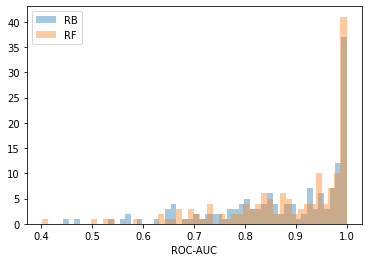

In [13]:
from scipy.stats.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from numpy.random import randn
seed(1)

rotation_forest_auc_scores = groupby_experiments_results_df.query("algorithm_name=='RotationForest'")['AUC']
rotboost_auc_scores = groupby_experiments_results_df.query("algorithm_name=='RotBoost'")['AUC']

# conduct the test
alpha = 0.05
result = mannwhitneyu(rotation_forest_auc_scores, rotboost_auc_scores, alternative='two-sided')
print(result)

if result[1] <= alpha:
	print(f"p-value is less than {alpha}.\nSo we have sufficient confidence for rejecting the null hypothesis and accepting the alternative")
else:
	print(f"p-value is greater than {alpha}.\nThus, we don't have sufficient confidence for rejecting the null hypothesis and accepting the alternative")
 
ax = sns.distplot(rotboost_auc_scores, bins=50, kde=False, hist=True, label="RB")
ax = sns.distplot(rotation_forest_auc_scores, bins=50, kde=False, hist=True, label="RF")
ax = plt.legend()
ax = plt.xlabel("ROC-AUC")

### Part 5 - Meta-Learning model

#### Classification All Meta Features Pre-processing

In [14]:
meta_df = pd.read_csv('ClassificationAllMetaFeatures.csv')

# Find the columns where all samples' value is nan/empty
empty_cols = find_empty_columns(meta_df)

# Drop empty columns from the dataframe
if len(empty_cols) > 0:
    print("Classification All Meta Features csv contains empty columns {}, dropping".format(empty_cols))
    meta_df.drop(empty_cols, axis=1, inplace=True)

# setting "dataset" column to serve as index and drop it as column from meta dataframe
meta_df.index = meta_df.dataset
meta_df = meta_df.drop(columns=['dataset'])

# imputers
meta_df, _ = apply_numeric_impute_mapper_on_data(meta_df)
meta_df, _ = apply_categorical_impute_mapper_on_data(meta_df)
meta_df = apply_ohe_mapper_on_data(meta_df)

# remove columns with one value
columns_with_one_value = find_columns_with_one_value_for_all_rows(meta_df)
if len(columns_with_one_value) > 0:
    print("Classification All Meta Features csv contains one value columns {}, dropping".format(columns_with_one_value))
    meta_df.drop(columns_with_one_value, axis=1, inplace=True)

# add binary target column
meta_df['label'] = np.array(groupby_experiments_results_df.query("algorithm_name=='RotBoost'")['AUC'].values >= groupby_experiments_results_df.query("algorithm_name=='RotationForest'")['AUC'].values) * 1

X, y = meta_df.drop(columns=['label']), meta_df['label']

Classification All Meta Features csv contains empty columns ['Unnamed: 143'], dropping
Classification All Meta Features csv contains one value columns ['ratio_of_discrete_features', 'ratio_of_numeric_features', 'attributes categorical'], dropping


#### Leave One Out CV

In [15]:
loocv = LeaveOneOut()

y_prob = []
y_pred = []

for train_index, test_index in loocv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    xgb_model = XGBClassifier(objective='binary:logistic', seed=0)
    xgb_model.fit(X_train, y_train)

    y_prob.append(xgb_model.predict_proba(X_test)[0,1])
    y_pred.append(xgb_model.predict(X_test)[0])

In [16]:
# Train meta model on all data
meta_model = XGBClassifier(objective='binary:logistic', seed=0)
train_start = time.time()
meta_model.fit(X, y)
train_stop = time.time()
training_time_sec = train_stop - train_start

inference_time_sec = measure_sec_of_n_sample_predictions(meta_model, X)

#### Meta metrics calculation

In [17]:
print(f"{'Accuracy':<16} {accuracy_score(y, y_pred)}")
print(f"{'TPR':<16} {tpr_score(y.values, y_pred)}")
print(f"{'FPR':<16} {fpr_score(y.values, y_pred)}")
print(f"{'Precision':<16} {precision_score(y.values, y_pred)}")
print(f"{'AUC':<16} {roc_auc_score(y, y_prob)}")
precision, recall, _ = precision_recall_curve(y, y_prob)
print(f"{'PR-Curve':<16} {auc(recall, precision)}")
print(f"{'Training Time':<16} {training_time_sec}")
print(f"{'Inference Time':<16} {inference_time_sec}")

Accuracy         0.58
TPR              0.5254668930390493
FPR              0.47453310696095075
Precision        0.425
AUC              0.5485757404263346
PR-Curve         0.4399750866654196
Training Time    0.15935707092285156
Inference Time   0.022748311360677086


#### Feature importance

###### Weight - Feature Importance

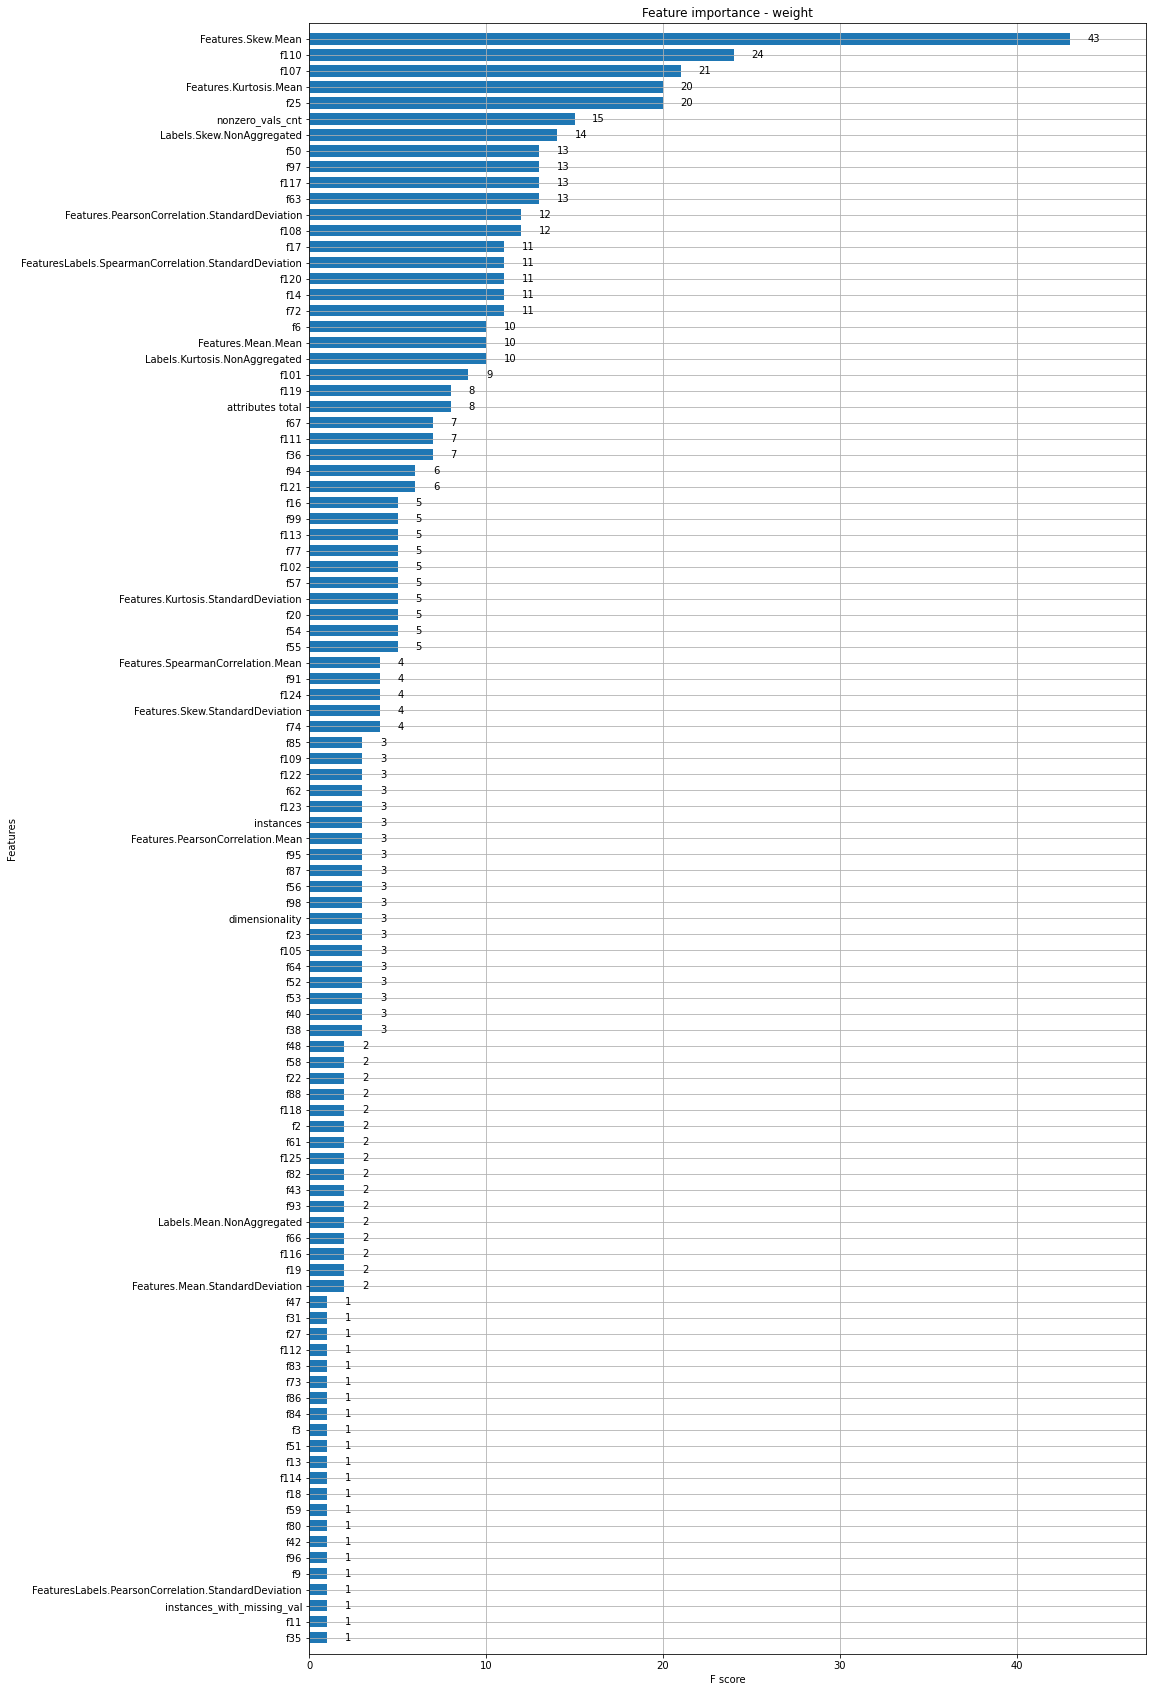

In [18]:
# plot 'Feature importance - weight
# "weight" is the number of times a feature is used to split the data across all trees.
f, ax = plt.subplots(figsize=(15, 30))
ax = xgboost.plot_importance(meta_model, ax=ax, height=0.7, title='Feature importance - weight')
plt.savefig("feature_importance_weight.png")
plt.show()

###### Gain - Feature Importance

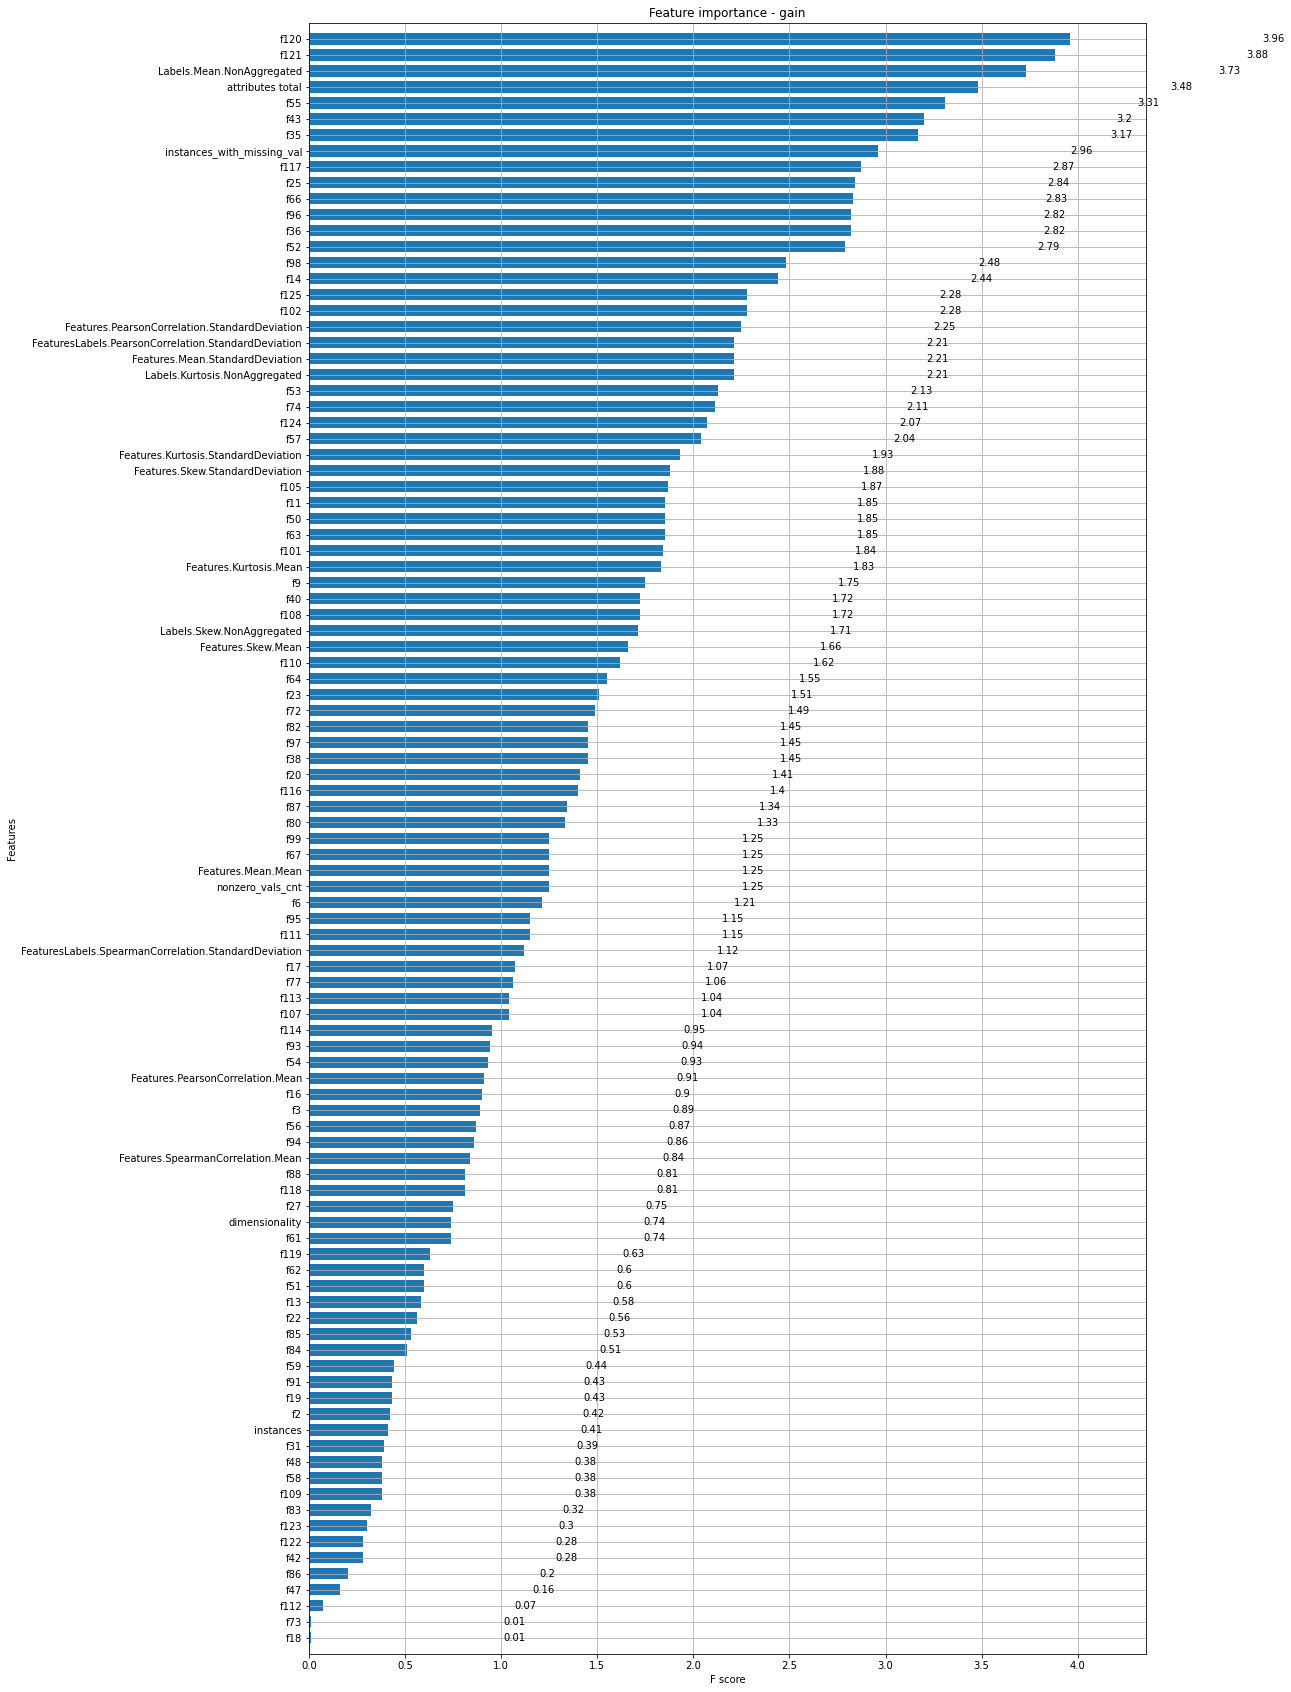

In [19]:
# plot 'Feature importance - gain'
# "gain" is the average training loss reduction gained when using a feature for splitting.
f, ax = plt.subplots(figsize=(15, 30))

booster = meta_model.get_booster()

# Get the importance dictionary (by gain) from the booster
importance = booster.get_score(importance_type="gain")

# make your changes
for key in importance.keys():
  importance[key] = round(importance[key],2)

ax = xgboost.plot_importance(importance, ax=ax, height=0.7, title='Feature importance - gain', importance_type='gain')
plt.savefig("feature_importance_gain.png")
plt.show()

###### Cover - Feature Importance

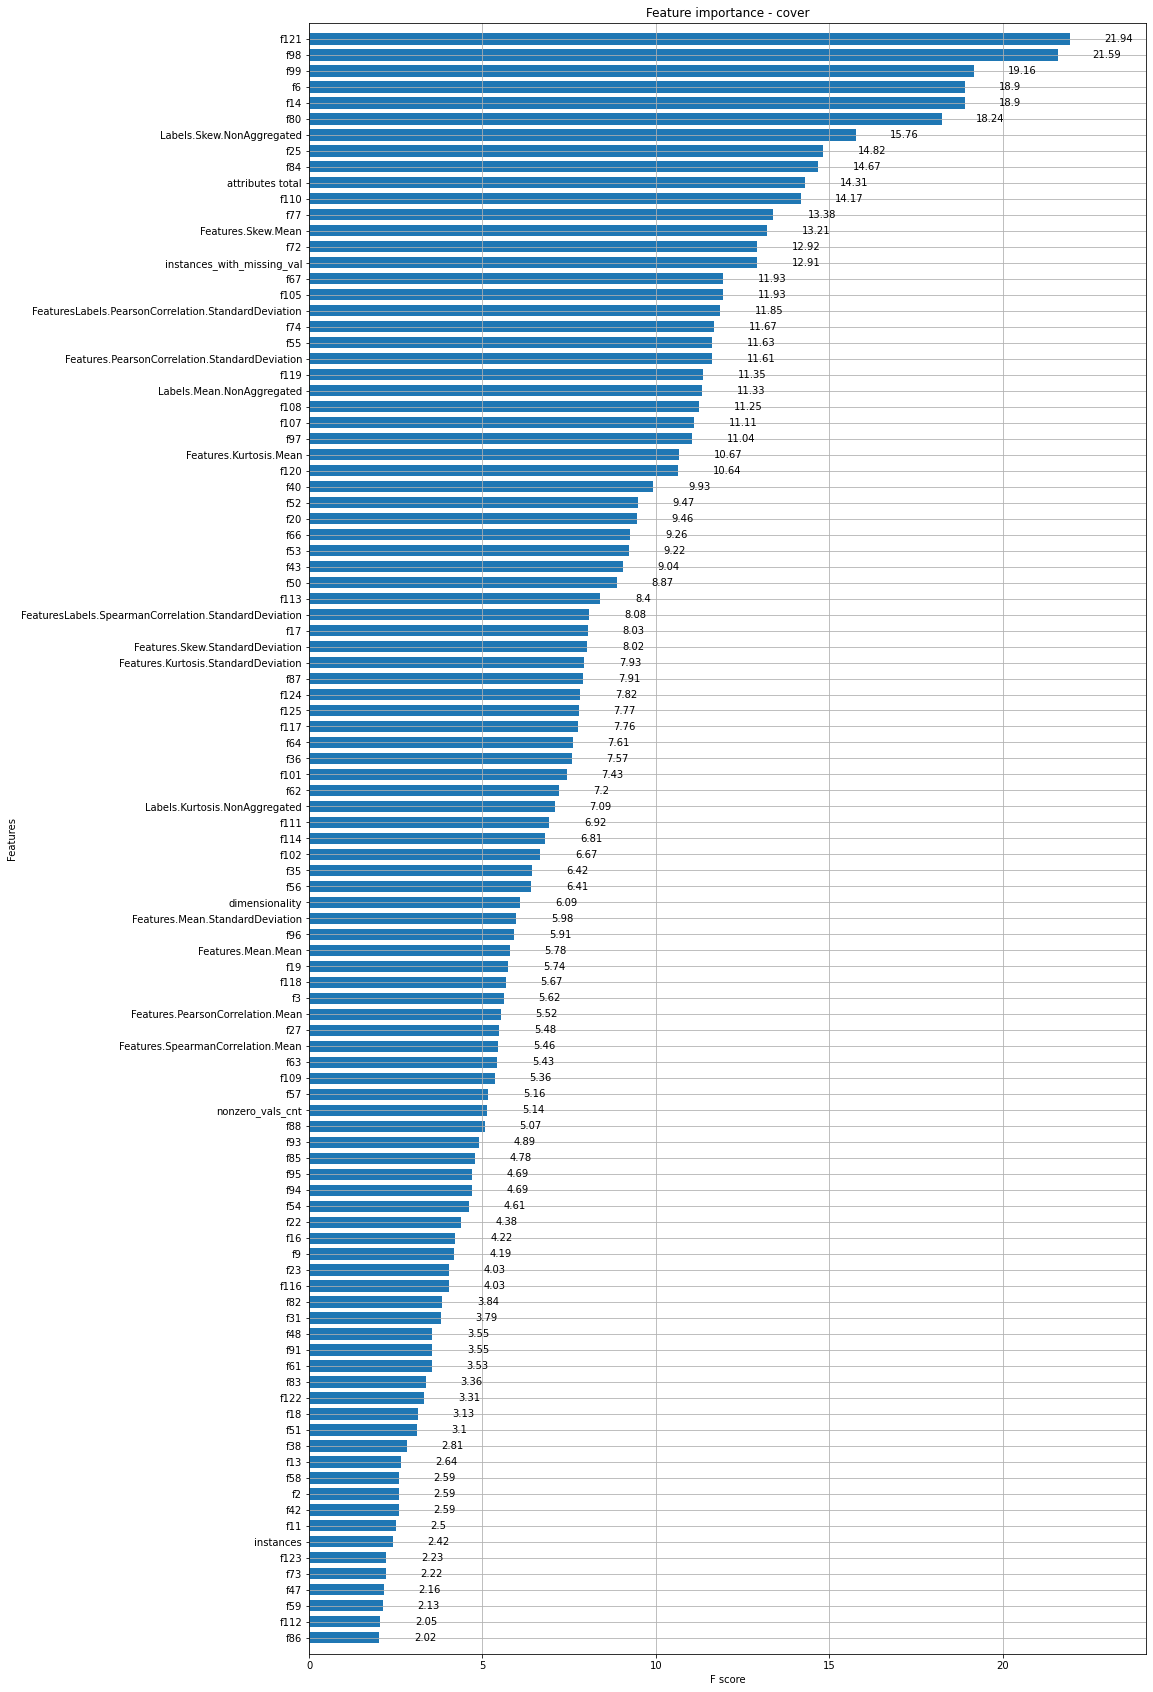

In [20]:
# plot 'Feature importance - cover'
# "cover" is the number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
f, ax = plt.subplots(figsize=(15, 30))

booster = meta_model.get_booster()

# Get the importance dictionary (by gain) from the booster
importance = booster.get_score(importance_type="cover")

# make your changes
for key in importance.keys():
  importance[key] = round(importance[key],2)

ax = xgboost.plot_importance(importance, ax=ax, height=0.7, title='Feature importance - cover', importance_type='cover')
plt.savefig("feature_importance_cover.png")
plt.show()

#### Shap

##### Visualize the training set prediction

In [21]:
# visualize the #2 prediction's explanation
explainer = shap.TreeExplainer(meta_model)
shap_values = explainer.shap_values(X)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:], link='logit')

In [22]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X)

##### Shap summary plot

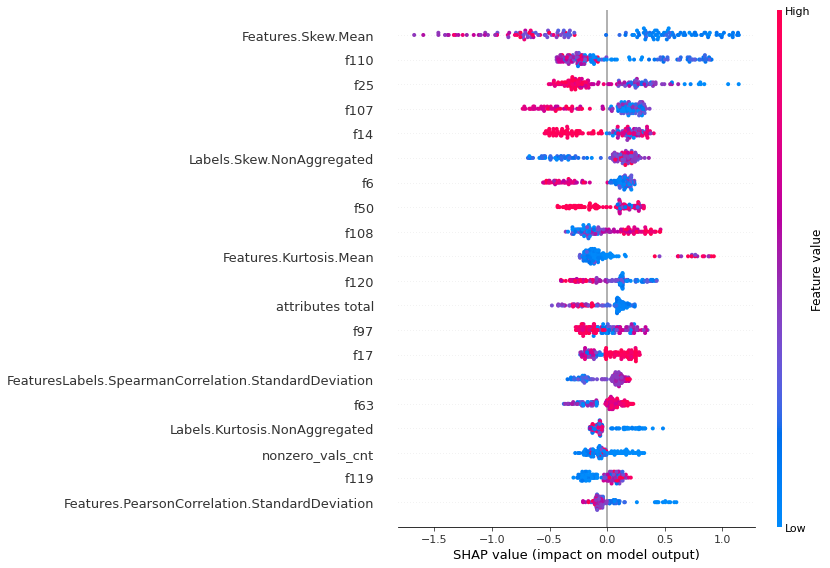

In [23]:
shap.initjs()
shap.summary_plot(shap_values, X)

##### Dependence contribution plots of the 5 most significant

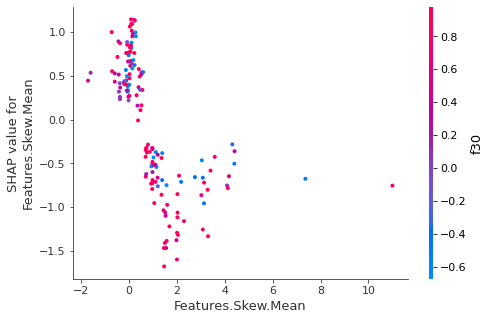

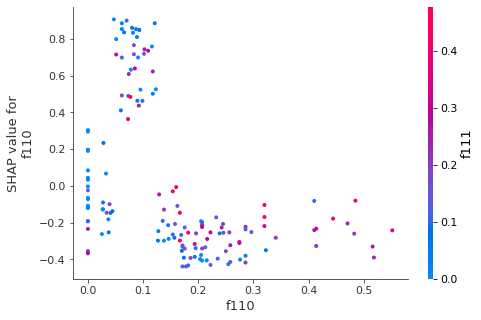

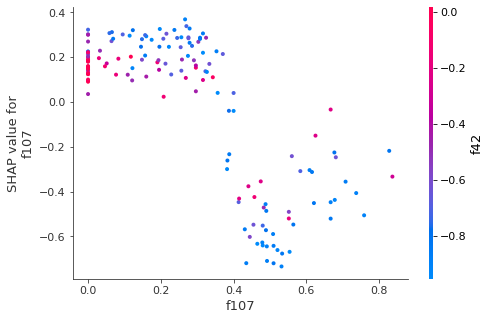

In [24]:
shap.dependence_plot("Features.Skew.Mean", shap_values, X)
shap.dependence_plot("f110", shap_values, X)
shap.dependence_plot("f107", shap_values, X)

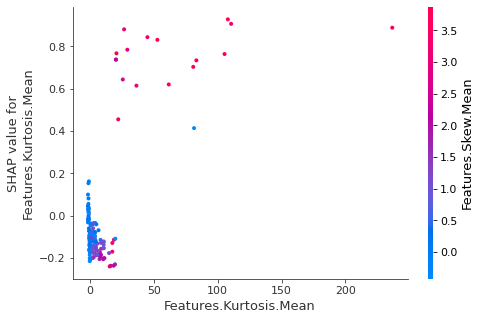

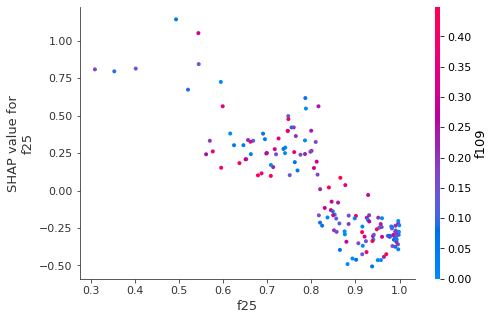

In [25]:
shap.dependence_plot("Features.Kurtosis.Mean", shap_values, X)
shap.dependence_plot("f25", shap_values, X)

### Part 6 - Report

See report word document

### Auxiliary

##### Experiments Results - metrics comparisons - RotBoost vs Rotation-Forest

In [26]:
def map_each_dataset_to_binary_or_multiclass(datasets_path: str) -> pd.DataFrame:

    data = []

    for i, transformed_dataset_filename in enumerate(sorted(os.listdir(datasets_path))):
        # save dataset name without csv/pkl suffix
        dataset_name = transformed_dataset_filename.partition(".")[0]

        # load data
        df = pd.read_pickle(datasets_path + '/' + transformed_dataset_filename)

        # Split training into X & y convention
        target_column_name = df.columns[-1]
        X, y = df.drop([target_column_name], axis=1), df.iloc[:, -1]

        if type_of_target(y) in 'binary':
            data.append([dataset_name, 'binary'])
        else:
          data.append([dataset_name, 'multiclass'])

    return pd.DataFrame(data, columns=['dataset_name', 'type'])

dataset_types_df = map_each_dataset_to_binary_or_multiclass('classification_datasets_transformed')
groupby_experiments_results_with_dataset_type_df = pd.merge(groupby_experiments_results_df, dataset_types_df, on='dataset_name')

In [27]:
def collect_information_and_metadata_on_datasets(datasets_path: str) -> pd.DataFrame:

    data = []

    for i, transformed_dataset_filename in enumerate(sorted(os.listdir(datasets_path))):
        # save dataset name without csv/pkl suffix
        dataset_name = transformed_dataset_filename.partition(".")[0]

        # load data
        df = pd.read_pickle(datasets_path + '/' + transformed_dataset_filename)

        # Split training into X & y convention
        target_column_name = df.columns[-1]
        X, y = df.drop([target_column_name], axis=1), df.iloc[:, -1]

        if type_of_target(y) in 'binary':
            data.append([dataset_name, 'binary', y.nunique(), X.shape[0], X.shape[1]])
        else:
          data.append([dataset_name, 'multiclass', y.nunique(), X.shape[0], X.shape[1]])

    return pd.DataFrame(data, columns=['dataset_name', 'type', 'class', 'cases', 'attribues'])

datasets_df = collect_information_and_metadata_on_datasets('classification_datasets_transformed')
datasets_df.to_csv("dataset-metadata.csv")

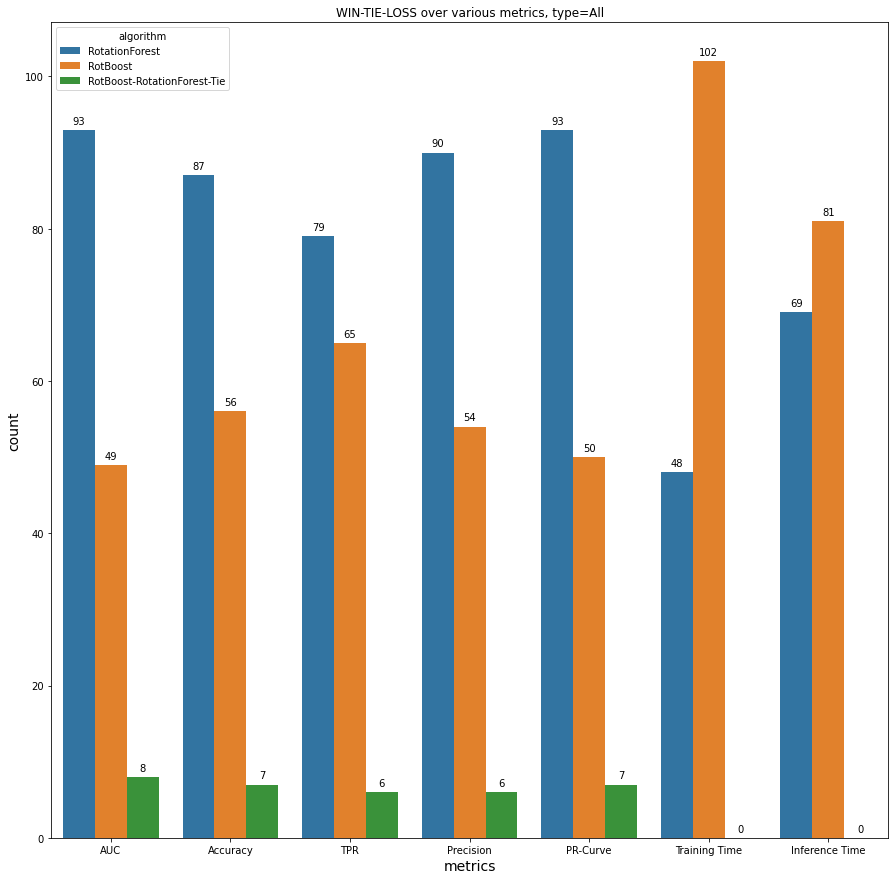

In [28]:
def plot_comparison_over_metrics(df, model_a, model_b, savefig=True, savefig_name="temp.png", type="All"):
  number_which_model_a_is_better_auc = count_based_on_given_metric(df, "AUC", "\'" + model_a + "\'", "\'" + model_b + "\'")
  number_which_model_a_is_better_accuracy = count_based_on_given_metric(df, "Accuracy", "\'" + model_a + "\'", "\'" + model_b + "\'")
  number_which_model_a_is_better_TPR = count_based_on_given_metric(df, "TPR", "\'" + model_a + "\'", "\'" + model_b + "\'")
  number_which_model_a_is_better_precision = count_based_on_given_metric(df, "Precision", "\'" + model_a + "\'", "\'" + model_b + "\'")
  number_which_model_a_is_better_pr_auc = count_based_on_given_metric(df, "PR-Curve", "\'" + model_a + "\'", "\'" + model_b + "\'")
  number_which_model_a_is_better_training_time = count_based_on_given_metric(df, "Training Time", "\'" + model_b + "\'", "\'" + model_a + "\'")
  number_which_model_a_is_better_inference_time = count_based_on_given_metric(df, "Inference Time", "\'" + model_b + "\'", "\'" + model_a + "\'")

  number_which_model_b_is_better_auc = count_based_on_given_metric(df, "AUC", "\'" + model_b + "\'", "\'" + model_a + "\'")
  number_which_model_b_is_better_accuracy = count_based_on_given_metric(df, "Accuracy", "\'" + model_b + "\'", "\'" + model_a + "\'")
  number_which_model_b_is_better_TPR = count_based_on_given_metric(df, "TPR", "\'" + model_b + "\'", "\'" + model_a + "\'")
  number_which_model_b_is_better_precision = count_based_on_given_metric(df, "Precision", "\'" + model_b + "\'", "\'" + model_a + "\'")
  number_which_model_b_is_better_pr_auc = count_based_on_given_metric(df, "PR-Curve", "\'" + model_b + "\'", "\'" + model_a + "\'")
  number_which_model_b_is_better_training_time = count_based_on_given_metric(df, "Training Time", "\'" + model_a + "\'", "\'" + model_b + "\'")
  number_which_model_b_is_better_inference_time = count_based_on_given_metric(df, "Inference Time", "\'" + model_a + "\'", "\'" + model_b + "\'")

  total = df.shape[0] / 2

  tie_auc = total - number_which_model_a_is_better_auc - number_which_model_b_is_better_auc
  tie_accuracy = total - number_which_model_a_is_better_accuracy - number_which_model_b_is_better_accuracy
  tie_TPR = total - number_which_model_a_is_better_TPR - number_which_model_b_is_better_TPR
  tie_precision = total - number_which_model_a_is_better_precision - number_which_model_b_is_better_precision
  tie_pr_auc = total - number_which_model_a_is_better_pr_auc - number_which_model_b_is_better_pr_auc
  tie_training_time = total - number_which_model_a_is_better_training_time - number_which_model_b_is_better_training_time
  tie_inference_time = total - number_which_model_a_is_better_inference_time - number_which_model_b_is_better_inference_time

  tie_name = '{}-{}-Tie'.format(model_a, model_b)
  statistics_data = [[model_b, 'AUC', number_which_model_b_is_better_auc], [model_a, 'AUC', number_which_model_a_is_better_auc], [tie_name, 'AUC', tie_auc],
                    [model_b, 'Accuracy', number_which_model_b_is_better_accuracy], [model_a, 'Accuracy', number_which_model_a_is_better_accuracy], [tie_name, 'Accuracy', tie_accuracy],
                    [model_b, 'TPR', number_which_model_b_is_better_TPR], [model_a, 'TPR', number_which_model_a_is_better_TPR], [tie_name, 'TPR', tie_TPR],
                    [model_b, 'Precision', number_which_model_b_is_better_precision], [model_a, 'Precision', number_which_model_a_is_better_precision], [tie_name, 'Precision', tie_precision],
                    [model_b, 'PR-Curve', number_which_model_b_is_better_pr_auc], [model_a, 'PR-Curve', number_which_model_a_is_better_pr_auc], [tie_name, 'PR-Curve', tie_pr_auc],
                    [model_b, 'Training Time', number_which_model_b_is_better_training_time], [model_a, 'Training Time', number_which_model_a_is_better_training_time], [tie_name, 'Training Time', tie_training_time],
                    [model_b, 'Inference Time', number_which_model_b_is_better_inference_time], [model_a, 'Inference Time', number_which_model_a_is_better_inference_time], [tie_name, 'Inference Time', tie_inference_time]] 
    
  # Create the pandas DataFrame 
  stat_df = pd.DataFrame(statistics_data, columns = ['algorithm', 'metric', 'count'])

  plt.figure(figsize=(15,15))
  splot = sns.barplot(x="metric", y="count", hue="algorithm", data=stat_df)

  for p in splot.patches:
      splot.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
  plt.xlabel("metrics", size=14)
  plt.ylabel("count", size=14)
  plt.title("WIN-TIE-LOSS over various metrics, type=" + type)
  plt.savefig(savefig_name)
  plt.show()

plot_comparison_over_metrics(groupby_experiments_results_df, "RotBoost", "RotationForest", savefig_name="metrics_comparison.png")

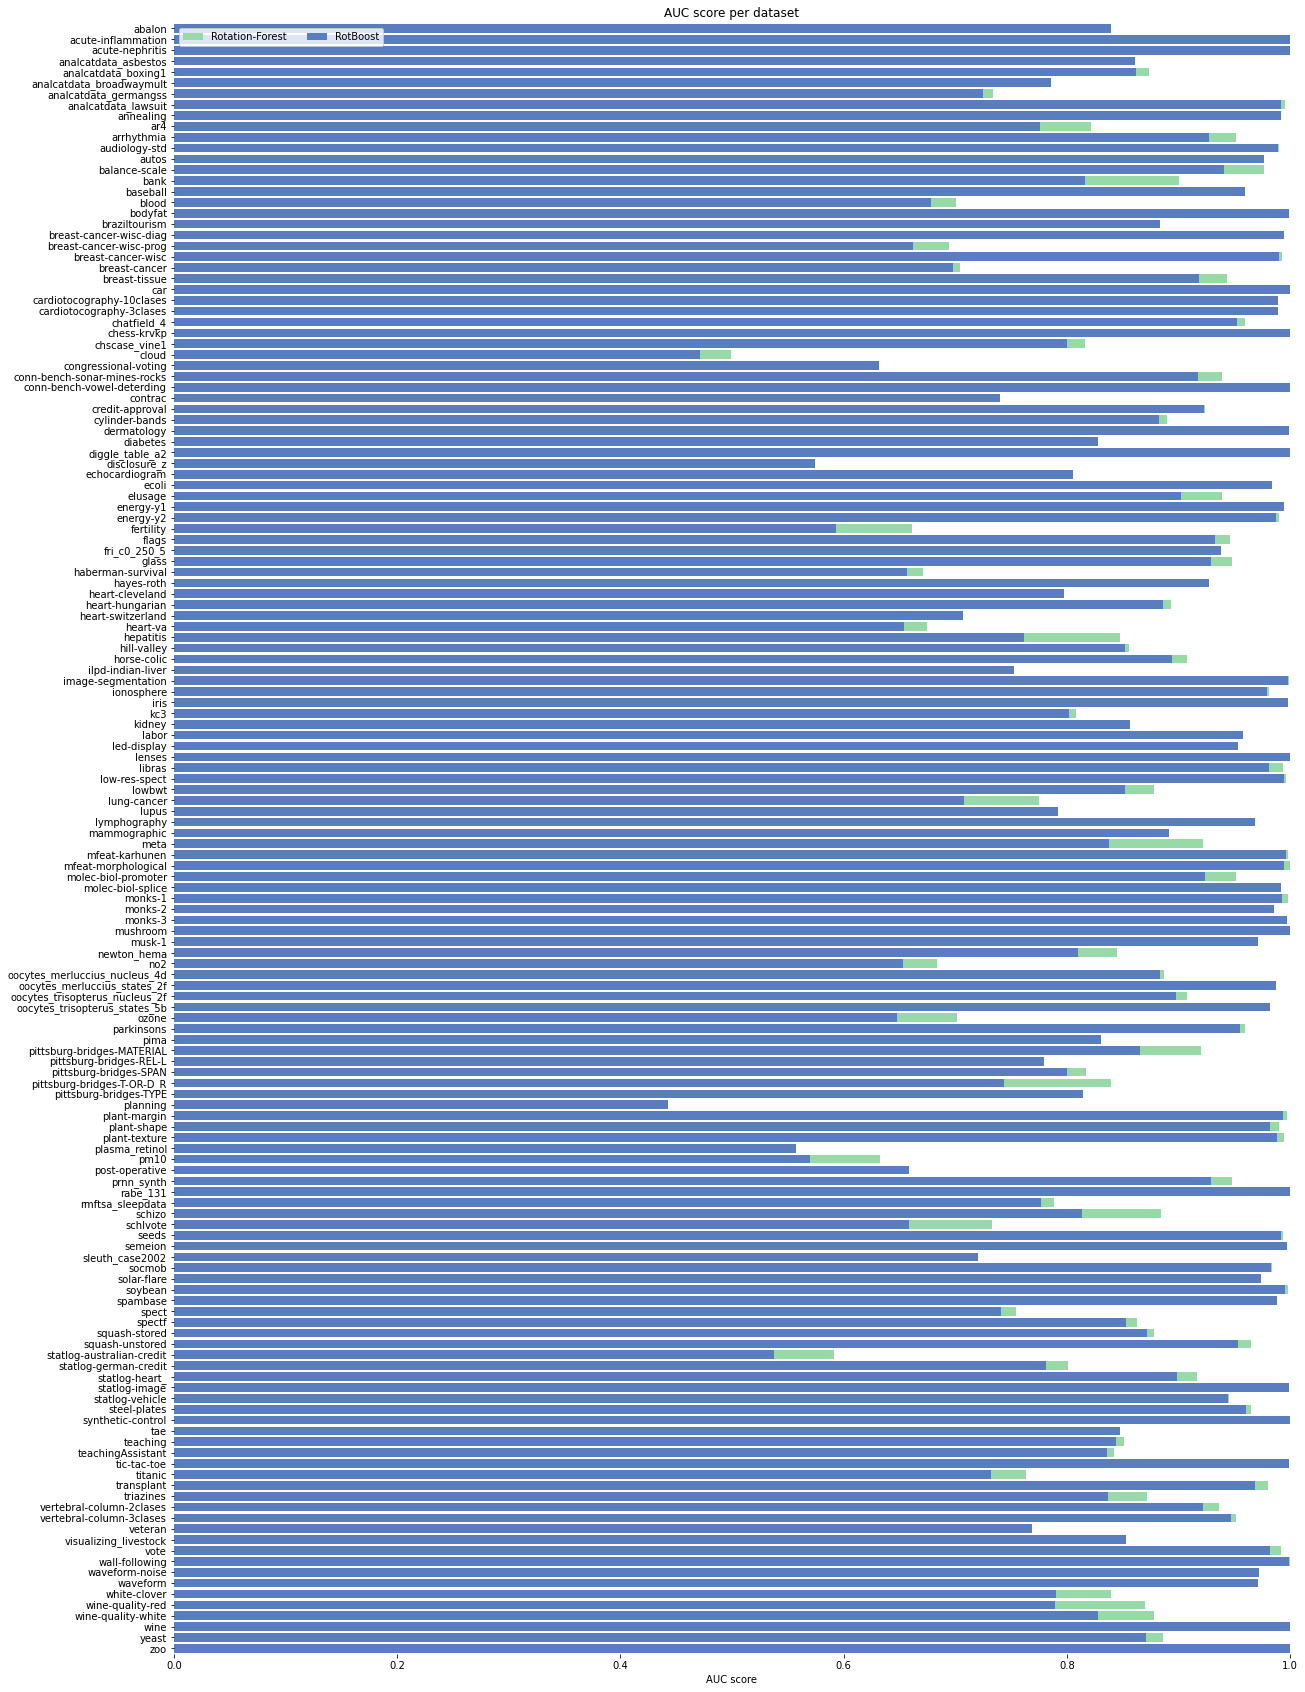

In [29]:
# AUC score per dataset

import matplotlib.pyplot as plt

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20, 30))

sns.set_color_codes("pastel")
sns.barplot(x="AUC", y="dataset_name", data=groupby_experiments_results_df.loc[groupby_experiments_results_df["algorithm_name"] == "RotationForest"],
            label="Rotation-Forest", color="g")

sns.set_color_codes("muted")
sns.barplot(x="AUC", y="dataset_name", data=groupby_experiments_results_df.loc[groupby_experiments_results_df["algorithm_name"] == "RotBoost"],
            label="RotBoost", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper left", frameon=True)
ax.set(xlim=(0, 1), ylabel="", xlabel="AUC score")
ax.set_title("AUC score per dataset")
sns.despine(left=True, bottom=True)

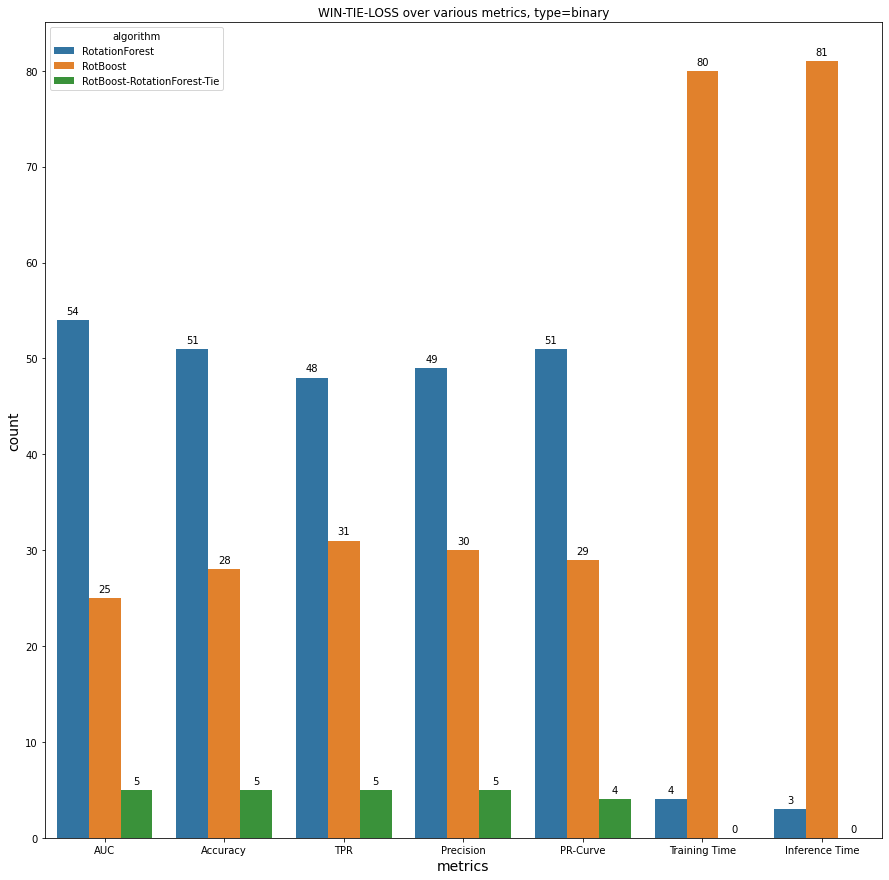

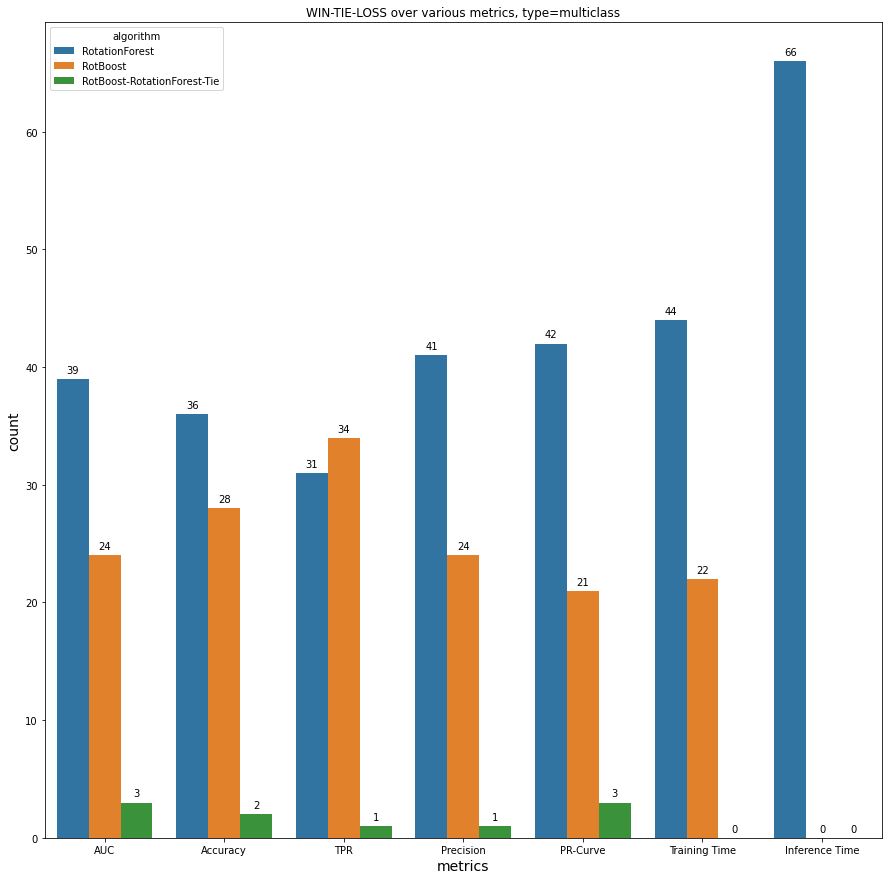

In [30]:
plot_comparison_over_metrics(groupby_experiments_results_with_dataset_type_df.loc[groupby_experiments_results_with_dataset_type_df["type"] == 'binary'], "RotBoost", "RotationForest", savefig_name="metrics_comparison_binary.png", type='binary')
plot_comparison_over_metrics(groupby_experiments_results_with_dataset_type_df.loc[groupby_experiments_results_with_dataset_type_df["type"] == 'multiclass'], "RotBoost", "RotationForest", savefig_name="metrics_comparison_multiclass.png", type='multiclass')

##### Illustration over schlvote dataset

In [31]:
# illustration of RotBoost algorithm using the following settings:
# Z=3, T=3, K=3, AdaBoost learning rate=1, random_state=0, and we use a decision tree stump as base inducer for AdaBoost.
# schlvote dataset (Table 1) is used as the training set, which have 38 samples and 4 features.
# see report document for more details

from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import graphviz 
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
fig = plt.figure(figsize=(10,10))

df = pd.read_pickle(transformed_datasets_dir_name + '/schlvote.csv.pkl')
target_column_name = df.columns[-1]
X, y = df.drop([target_column_name], axis=1), df.iloc[:, -1]

clf = RotBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=0), n_estimators=3, n_estimators_of_adaboost=3, n_features_per_subset=3, random_state=0)
clf = clf.fit(X, y)

<Figure size 720x720 with 0 Axes>

$M_1$ Classifier weights and errors:

In [32]:
print(clf.estimators_[0].adaboost_classifier.estimator_weights_)
print(clf.estimators_[0].adaboost_classifier.estimator_errors_)

[0.66087792 0.52767549 0.34441916]
[0.21052632 0.25819889 0.33429154]


$M_2$ Classifier weights and errors:

In [33]:
print(clf.estimators_[1].adaboost_classifier.estimator_weights_)
print(clf.estimators_[1].adaboost_classifier.estimator_errors_)

[0.94353482 0.47176741 0.34082756]
[0.13157895 0.28018688 0.335892  ]


$M_3$ Classifier weights and errors:

In [34]:
print(clf.estimators_[2].adaboost_classifier.estimator_weights_)
print(clf.estimators_[2].adaboost_classifier.estimator_errors_)

[0.66087792 0.57522999 0.48075932]
[0.21052632 0.24040508 0.27657424]


$M_1$ AdaBoost Decision trees stumps:

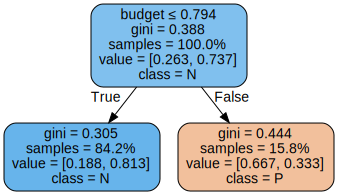

In [35]:
dot_data = tree.export_graphviz(clf.estimators_[0].adaboost_classifier.estimators_[0], out_file=None, 
                      feature_names=X.columns.to_list(),  
                     class_names=['P', 'N'],  
                      filled=True, rounded=True,  
                      special_characters=True, proportion=True)  
graph = graphviz.Source(dot_data)  
graph

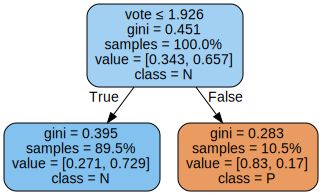

In [36]:
dot_data = tree.export_graphviz(clf.estimators_[0].adaboost_classifier.estimators_[1], out_file=None, 
                      feature_names=X.columns.to_list(),  
                     class_names=['P', 'N'],  
                      filled=True, rounded=True,  
                      special_characters=True, proportion=True)  
graph = graphviz.Source(dot_data)  
graph

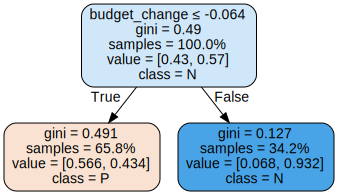

In [37]:
dot_data = tree.export_graphviz(clf.estimators_[0].adaboost_classifier.estimators_[2], out_file=None, 
                      feature_names=X.columns.to_list(),  
                     class_names=['P', 'N'],  
                      filled=True, rounded=True,  
                      special_characters=True, proportion=True)  
graph = graphviz.Source(dot_data)  
graph

$M_2$ AdaBoost Decision trees stumps:

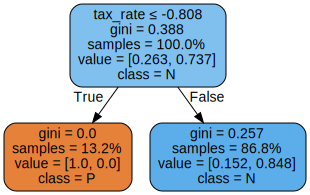

In [38]:
dot_data = tree.export_graphviz(clf.estimators_[1].adaboost_classifier.estimators_[0], out_file=None, 
                      feature_names=X.columns.to_list(),  
                     class_names=['P', 'N'],  
                      filled=True, rounded=True,  
                      special_characters=True, proportion=True)  
graph = graphviz.Source(dot_data)  
graph

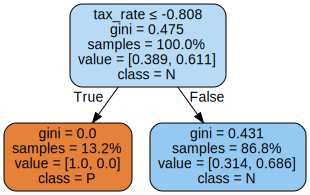

In [39]:
dot_data = tree.export_graphviz(clf.estimators_[1].adaboost_classifier.estimators_[1], out_file=None, 
                      feature_names=X.columns.to_list(),  
                     class_names=['P', 'N'],  
                      filled=True, rounded=True,  
                      special_characters=True, proportion=True)  
graph = graphviz.Source(dot_data)  
graph

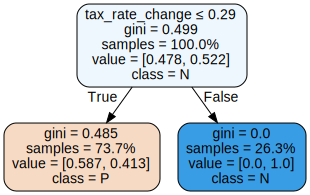

In [40]:
dot_data = tree.export_graphviz(clf.estimators_[1].adaboost_classifier.estimators_[2], out_file=None, 
                      feature_names=X.columns.to_list(),  
                     class_names=['P', 'N'],  
                      filled=True, rounded=True,  
                      special_characters=True, proportion=True)  
graph = graphviz.Source(dot_data)  
graph

$M_3$ AdaBoost Decision trees stumps:

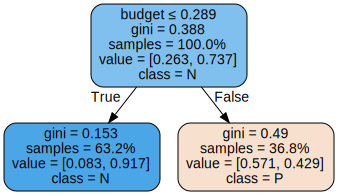

In [41]:
dot_data = tree.export_graphviz(clf.estimators_[2].adaboost_classifier.estimators_[0], out_file=None, 
                      feature_names=X.columns.to_list(),  
                     class_names=['P', 'N'],  
                      filled=True, rounded=True,  
                      special_characters=True, proportion=True)  
graph = graphviz.Source(dot_data)  
graph

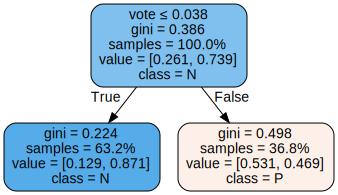

In [42]:
dot_data = tree.export_graphviz(clf.estimators_[2].adaboost_classifier.estimators_[1], out_file=None, 
                      feature_names=X.columns.to_list(),  
                     class_names=['P', 'N'],  
                      filled=True, rounded=True,  
                      special_characters=True, proportion=True)  
graph = graphviz.Source(dot_data)  
graph

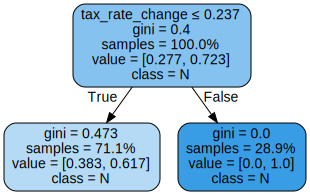

In [43]:
dot_data = tree.export_graphviz(clf.estimators_[2].adaboost_classifier.estimators_[2], out_file=None, 
                      feature_names=X.columns.to_list(),  
                     class_names=['P', 'N'],  
                      filled=True, rounded=True,  
                      special_characters=True, proportion=True)  
graph = graphviz.Source(dot_data)  
graph